In [36]:
import xarray as xr
import proplot as pplt
import pandas as pd
import numpy as np
from AOSCMcoupling.files import OIFSPreprocessor

In [37]:
start_date = pd.Timestamp("2020-04-16")
oifs_preprocessor = OIFSPreprocessor(
    start_date, np.timedelta64(-1, "h")
)
max_schwarz_iters = 30
oifs_diagvars_add_swz = []
for iter in range(1, max_schwarz_iters + 1):
    oifs_diagvars_add_swz.append(
        xr.open_mfdataset(
            f"output/TOPS_{iter}/diagvar.nc",
            preprocess=oifs_preprocessor.preprocess,
        )
    )

oifs_progvars_add_swz = []
for iter in range(1, max_schwarz_iters + 1):
    oifs_progvars_add_swz.append(
        xr.open_mfdataset(
            f"output/TOPS_{iter}/progvar.nc",
            preprocess=oifs_preprocessor.preprocess,
        )
    )

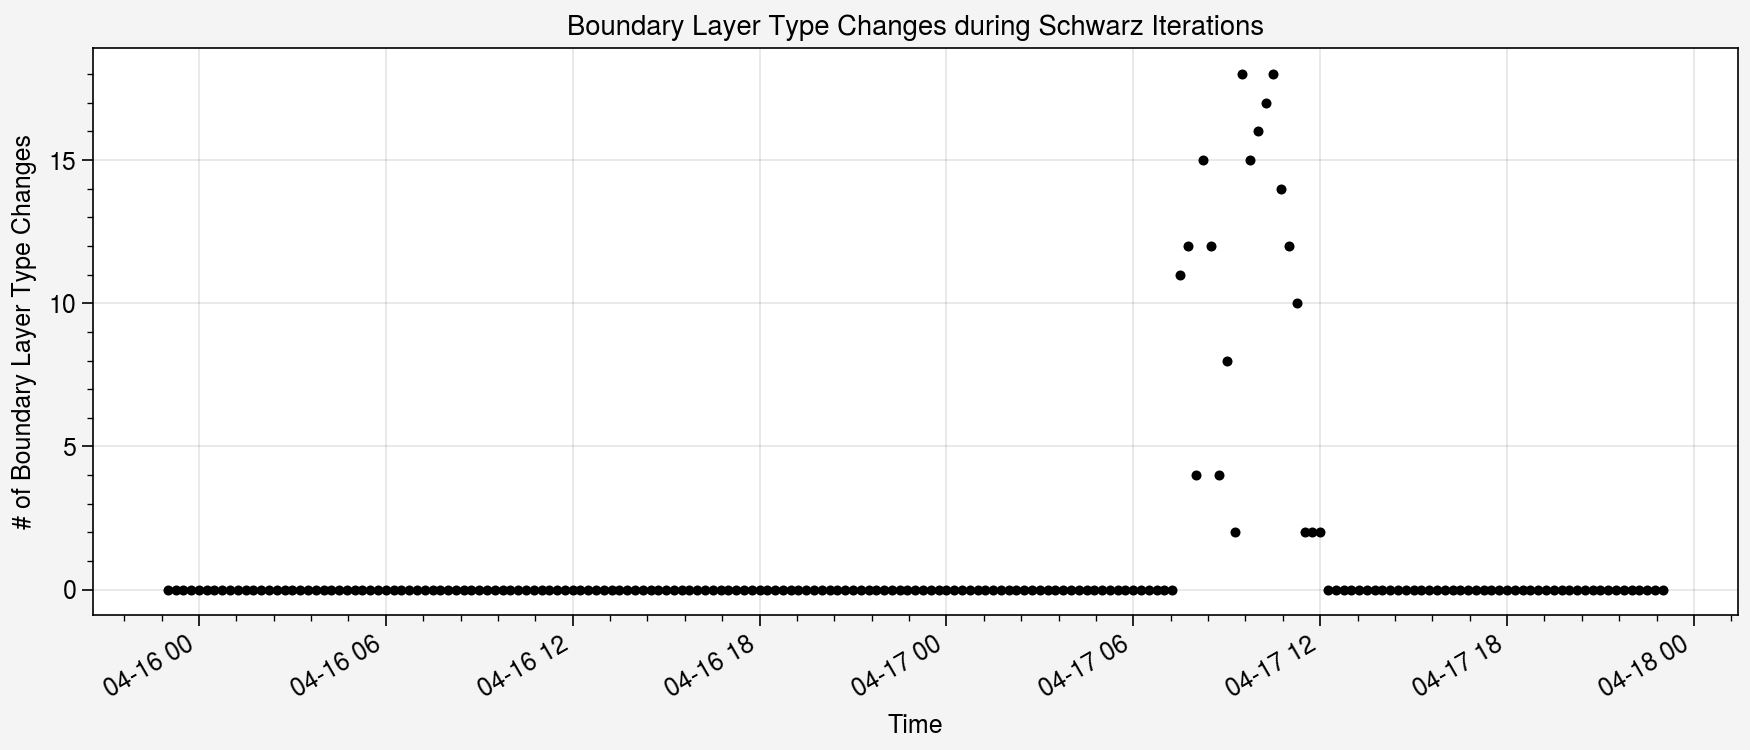

In [38]:
pbl_type_changes = oifs_diagvars_add_swz[0].pbl_type.copy()
pbl_type_changes.data[:] = 0
pbl_types = [oifs_diagvar.pbl_type for oifs_diagvar in oifs_diagvars_add_swz]

fig, ax = pplt.subplots(width="70em", height="30em")
previous_pbl_type = pbl_types[0]
type_changes_over_iters = []
for iter in range(1, max_schwarz_iters):
    pbl_type = pbl_types[iter]
    pbl_type_not_equal = np.where(pbl_type.data != previous_pbl_type.data)
    type_changes_over_iters.append(len(pbl_type_not_equal[0].compute()) / 385)
    pbl_type_changes.data[pbl_type_not_equal] += 1
    previous_pbl_type = pbl_type
ax.scatter(
    pbl_type_changes,
    color="k",
    marker=".",
)
ax.format(
    ylabel="# of Boundary Layer Type Changes",
    ytickminor=True,
    title="Boundary Layer Type Changes during Schwarz Iterations",
    xlabel="Time",
    xrotation=30,
    yticks=[0, 5, 10, 15, 20],
)
fig.savefig("plots/ece4_top_count_bl_changes.pdf")

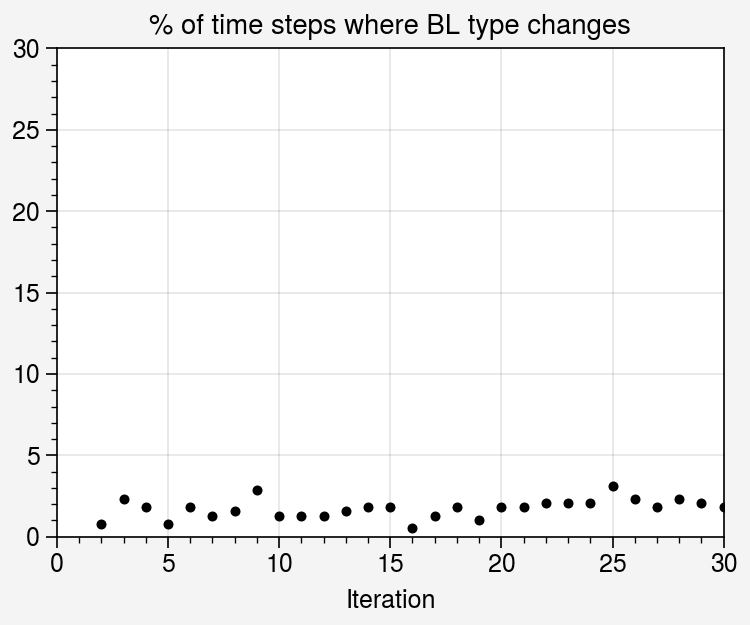

In [39]:
fig, ax = pplt.subplots(width="30em", height="25em")
ax.scatter(list(range(2, 31)), 100 * np.array(type_changes_over_iters), marker=".", color="k")
ax.format(
    title="% of time steps where BL type changes",
    xlabel="Iteration",
    ylim=[0, 30],
    xlim=[0, 30],
)
fig.savefig("plots/ece4_top_percent_bl_changes.pdf")

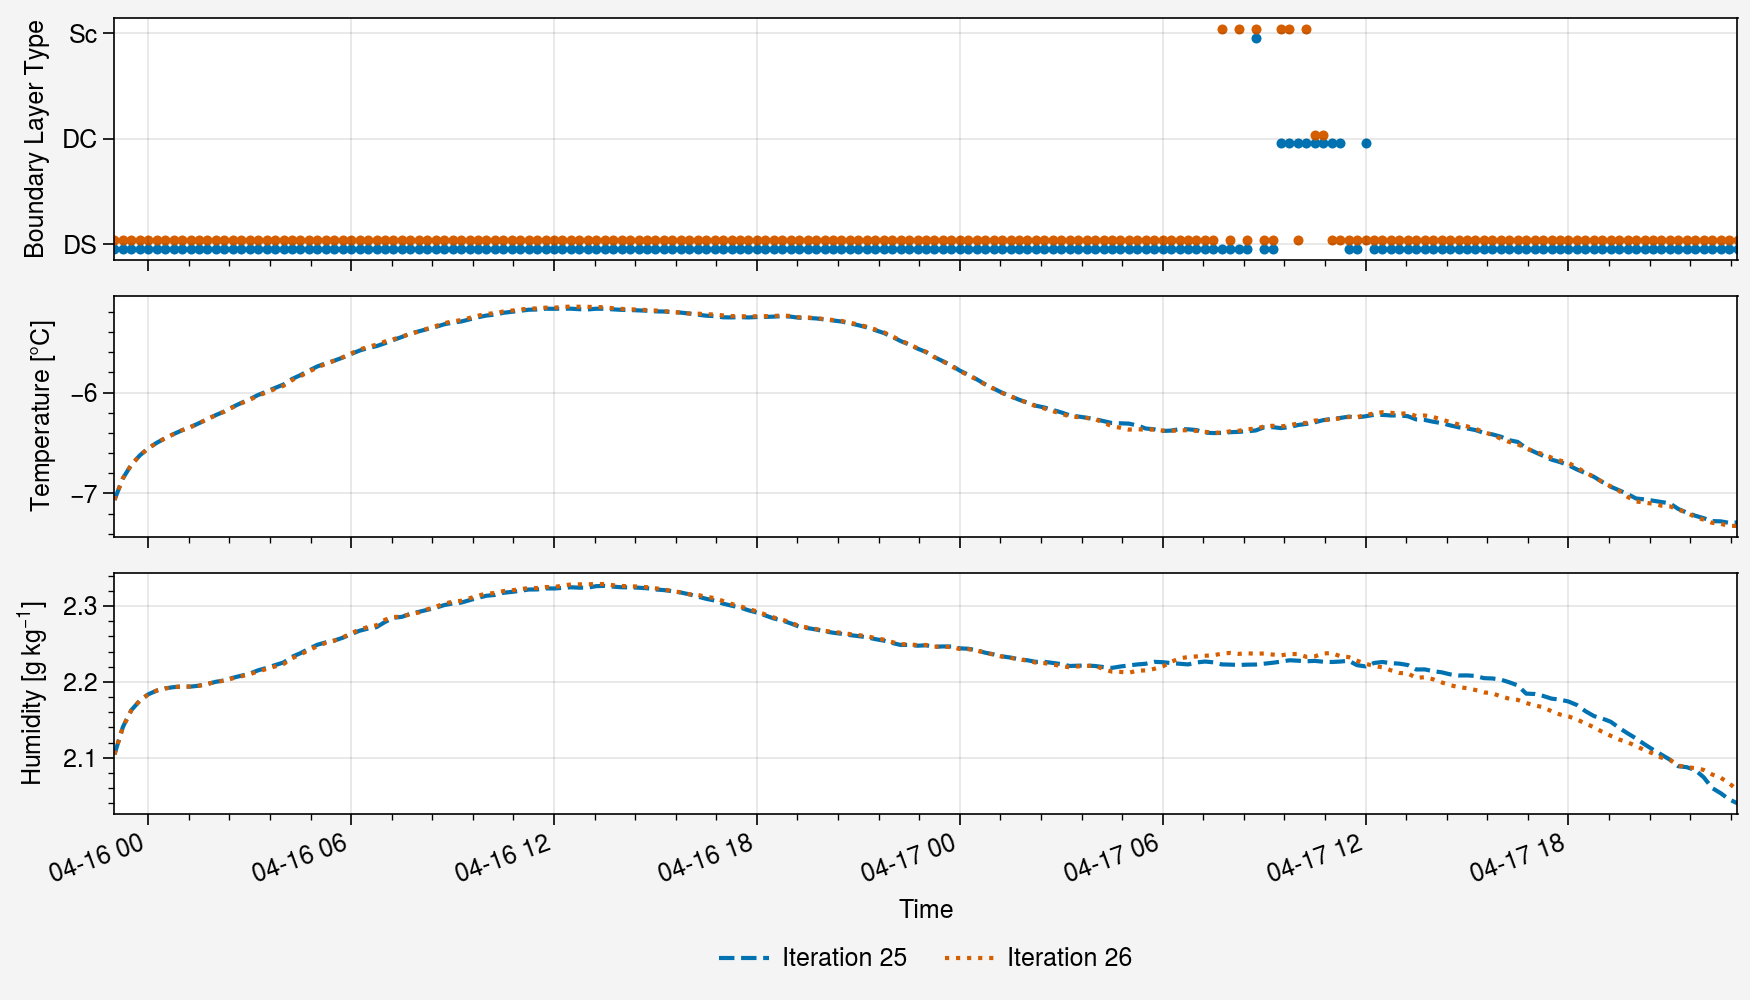

In [40]:
fig, axs = pplt.subplots(width="70em", nrows=3, height="40em", sharey=False)

base_iteration = 25
ax = axs[0]
shifts = [-0.04, 0.04]
for i in range(2):
    oifs_diagvar = oifs_diagvars_add_swz[base_iteration - 1 + i]
    ax.scatter(
        oifs_diagvar.pbl_type + shifts[i],
        marker=".",
        label=f"Iteration {base_iteration + i}",
    )
ax.format(
    ylabel="Boundary Layer Type",
    yticks=[0, 1, 2, 3],
    yticklabels=["DS", "DC", "Sc", "Cu"],
    ytickminor=False,
    xrotation=30,
    xlabel="Time",
)
linestyles = ["--", ":"]

ax = axs[1]
for i in range(2):
    ax.plot(
        oifs_progvars_add_swz[base_iteration + i - 1].t.sel(nlev=137) - 273.15,
        label=f"Iteration {base_iteration + i}",
        ls=linestyles[i],
    )
ax.format(ylabel="Temperature $[°C]$", title="", xlabel="Time")

hs = []
ax = axs[2]
for i in range(2):
    h = ax.plot(
        oifs_progvars_add_swz[base_iteration + i - 1].q.sel(nlev=137) * 1e3,
        label=f"Iteration {base_iteration + i}",
        ls=linestyles[i],
    )
    hs.append(h)
ax.format(
    ylabel="Humidity $[g\; kg^{{-1}}]$",
    title="",
    xlabel="Time",
    xrotation=20,
)

fig.legend(hs, ncols=4, frame=False, loc="b")
fig.savefig(f"plots/ece4_top_compare_iters{base_iteration}-{base_iteration+1}.pdf")